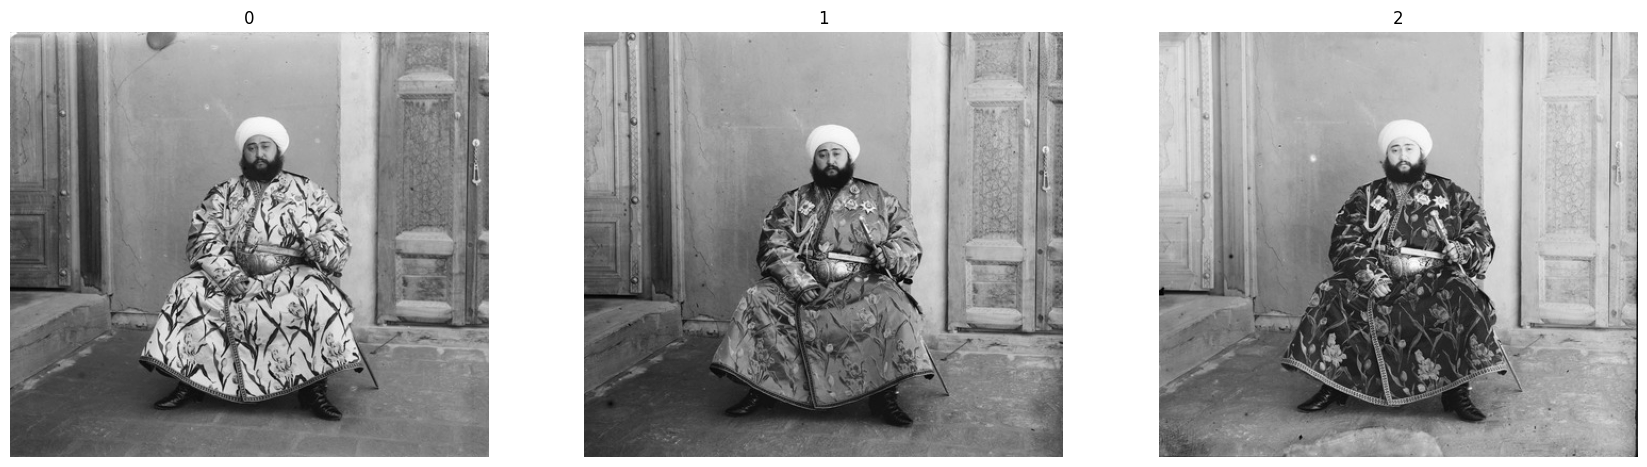

In [3]:
import cv2
import numpy as np
from utils import show_images

imgs = [cv2.imread(f'./image/registration/emir{i}.png', -1) for i in range(3)]

show_images([(f'{i}', imgs[i]) for i in range(3)])

[[ 1.00215440e+00  1.32773123e-04 -5.77647763e-01]
 [ 6.89723830e-04  1.00114167e+00 -1.64328572e-01]
 [ 3.96336213e-06 -2.82859320e-06  1.00000000e+00]]
[[ 1.00064885e+00  8.15198710e-04 -5.41527473e-02]
 [ 8.18164756e-05  1.00270353e+00 -1.46679237e-01]
 [ 6.17017370e-07  4.90825032e-06  1.00000000e+00]]
[[ 9.94996519e-01  1.02488287e-04 -2.46266736e+00]
 [-2.29688419e-03  9.95273457e-01  8.07958918e+00]
 [-2.23837247e-06 -4.60605178e-06  1.00016340e+00]]
[[ 9.04340718e-01  5.24972982e-02 -2.21675996e+00]
 [-8.47071810e-02  9.60727291e-01  2.44249287e+01]
 [-2.93759037e-04  1.00272509e-04  1.00217301e+00]]


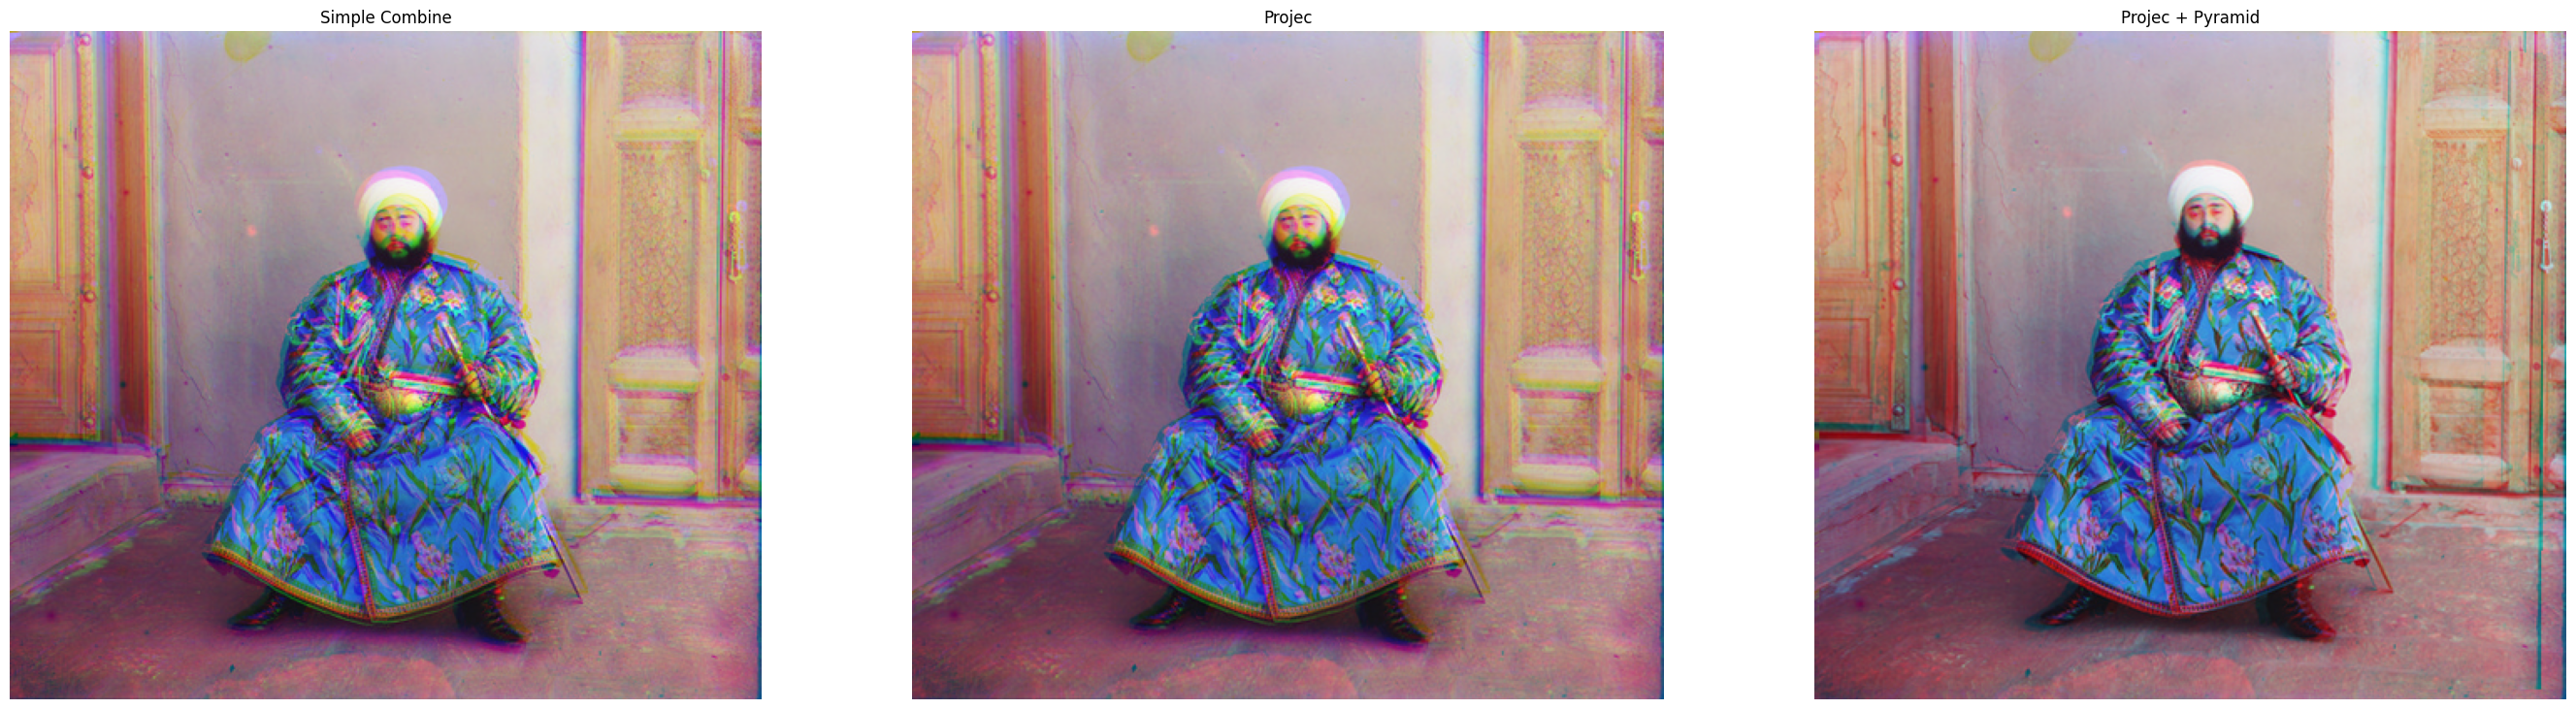

In [4]:
def new_img(imgs):
    newimg = np.zeros((imgs[0].shape[0], imgs[0].shape[1], 3), dtype=float)
    newimg[..., 0] = imgs[0]
    return newimg

results = []

# 直接合并
simple_combine = new_img(imgs)
for i in range(3):
    simple_combine[..., i] = imgs[i]
simple_combine = simple_combine.clip(0, 255).astype(np.uint8)
results.append(('Simple Combine', simple_combine))

# reg 模块
mappers = [
    # ('Shift',   cv2.reg.MapperGradShift(),   cv2.reg.MapTypeCaster.toShift),
    # ('Euclid',  cv2.reg.MapperGradEuclid(),  cv2.reg.MapTypeCaster.toAffine),
    # ('Similar', cv2.reg.MapperGradSimilar(), cv2.reg.MapTypeCaster.toAffine),
    # ('Affine',  cv2.reg.MapperGradAffine(),  cv2.reg.MapTypeCaster.toAffine),
    ('Projec',  cv2.reg.MapperGradProj(),    cv2.reg.MapTypeCaster.toProjec)
]

# 直接使用
for (mapper_name, mapper, mapper_cast) in mappers:
    now_img = new_img(imgs)
    for i in range(1, 3):
        # ! 重要：必须传入 float 类型！！
        map_ptr = mapper.calculate(imgs[0].astype(float), imgs[i].astype(float))
        real_map = mapper_cast(map_ptr)
        if mapper_name == 'Projec':
            print(real_map.getProjTr())
        now_img[..., i] = real_map.inverseWarp(imgs[i].astype(float))

    now_img = now_img.clip(0, 255).astype(np.uint8)
    results.append((mapper_name, now_img))


# 配合 Pyramid 使用
for (mapper_name, mapper, mapper_cast) in mappers:
    now_img = new_img(imgs)
    mapper_pyr = cv2.reg.MapperPyramid(mapper)
    for i in range(1, 3):
        map_ptr = mapper_pyr.calculate(imgs[0].astype(float), imgs[i].astype(float))
        real_map = mapper_cast(map_ptr)
        if mapper_name == 'Projec':
            print(real_map.getProjTr())
        now_img[..., i] = real_map.inverseWarp(imgs[i])
    now_img = now_img.clip(0, 255).astype(np.uint8)
    results.append((f'{mapper_name} + Pyramid', now_img))

show_images(results, colnum=3, scale=10)
